In [1]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise
import tomopy

In [2]:
data = tifffile.imread('/data/prj_alignment/shale_obj256.tiff')
print(data.shape)

(160, 256, 256)


In [3]:
def nor_data(img):
#     mean_tmp = np.mean(img)
#     std_tmp = np.std(img)
#     img = (img - mean_tmp) / std_tmp
    img = (img - img.min())/(img.max()-img.min())
    return img

In [4]:
ang = tomopy.angles(181)

In [5]:
# crop to FOI smaller than object
prj = tomopy.project(data, ang)
prj = nor_data(prj)
# prj = np.pad(prj, ((0, 0), (20, 20), (0, 0)))

In [6]:
prj = prj[:, 10:-10, 80:-80]

In [25]:
prj = tomopy.project(data, ang)
prj = np.pad(prj, ((0, 0), (20, 20), (0, 0)))
prj = nor_data(prj)

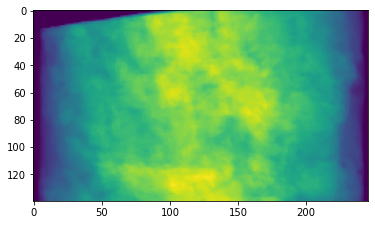

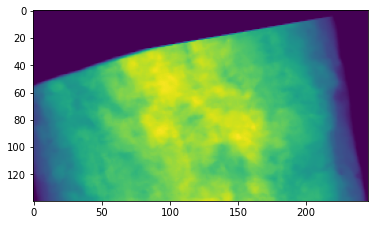

In [8]:
img = prj[10]
img_tmp = rotate(img, 10, center=(256, 256/2-0.5))
plt.imshow(img)
plt.show()
plt.imshow(img_tmp)
plt.show()

[[  1.   0.  40.]
 [  0.   1. -20.]]


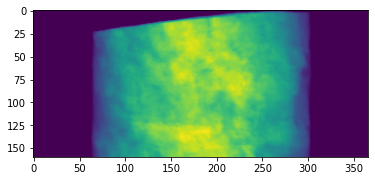

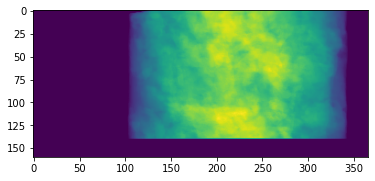

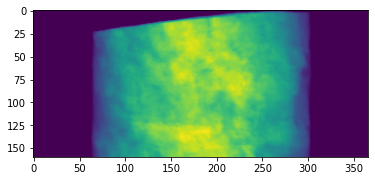

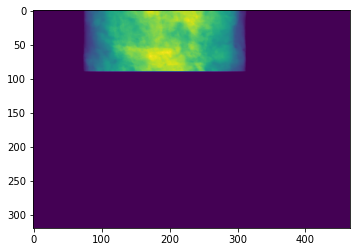

In [14]:
num_rows, num_cols = img.shape

translation_matrix = np.float32([ [1,0,40], [0,1,-20] ])
print(translation_matrix)

img_translation = cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))
plt.imshow(img)
plt.show()
plt.imshow(img_translation)
plt.show()

translation_matrix = np.float32([ [1,0,-30], [0,1,-50] ])

img_translation = cv2.warpAffine(img_translation, translation_matrix, (num_cols + 70 + 30, num_rows + 110 + 50))

plt.imshow(img)
plt.show()
plt.imshow(img_translation)
plt.show()


In [7]:
mis_axis = np.random.normal(0, 1, (200, 3))
mis_axis[:,:1] = mis_axis[:,:1]*4
mis_axis = np.round(mis_axis).astype(int)

In [8]:
tifffile.imsave('/data/prj_alignment/small_FOV/prj_crop_80.tiff', prj)

In [9]:
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    prj_tmp = np.zeros_like(prj)
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        translation_matrix = np.float32([ [1,0,d_row], [0,1,d_col] ])
        prj_tmp[i, :, :] = cv2.warpAffine(prj_tmp[i, :, :], translation_matrix, (row, col))
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()
    return prj_tmp

In [10]:
prj_new = misalign(prj, mis_axis, background=True)
tifffile.imsave('/data/prj_alignment/simulation/prj_misalign_xz_background.tiff', prj_new)

In [11]:
prj_new = misalign(prj, mis_axis)
tifffile.imsave('/data/prj_alignment/small_FOV/prj_misalign_xz.tiff', prj_new)

In [14]:
prj_new = misalign(prj, mis_axis, noise = True)
tifffile.imsave('/data/prj_alignment/simulation/prj_misalign_xz_noise01.tiff', prj_new)

In [169]:
d_row, d_col, d_ang = mis_axis[10]

In [18]:
np.random.random()/10

0.06449794169871566

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


In [67]:
def cal_ssim(img1, img2, img3):
    img1 = nor_data(img1)
    img2 = nor_data(img2)
    img3 = nor_data(img3)
    ssim1 = np.zeros((len(img1)))
    ssim2 = np.zeros((len(img1)))
    for i in range(len(img1)):
        
        ssim1[i] = ssim(nor_data(img1[i]), nor_data(img2[i]),
                                     data_range=img2.max() - img2.min())
        ssim2[i] = ssim(nor_data(img1[i]), nor_data(img3[i]), 
                                     data_range=img3.max() - img3.min())
    return ssim1, ssim2 

In [68]:
prj = tifffile.imread('/data/prj_alignment/simulation/prj_shale.tiff')
prj_mis = tifffile.imread('/data/prj_alignment/simulation/prj_misalign_xz.tiff')
prj_ali = tifffile.imread('/data/prj_alignment/simulation/xz_aligned_miao.tiff')

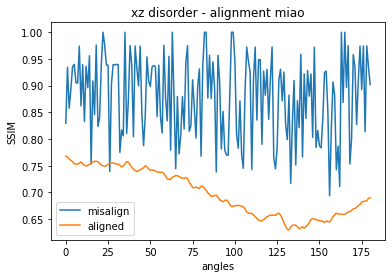

In [69]:
ssim1, ssim2 = cal_ssim(prj, prj_mis,prj_ali)
plt.plot(ssim1, label='misalign')
plt.plot(ssim2, label='aligned')
plt.legend()
plt.ylabel('SSIM')
plt.xlabel('angles')
plt.title('xz disorder - alignment miao')

plt.savefig('/data/prj_alignment/presentation/xz_miao.png', dpi = 300)

In [53]:
print(ssim2)


[0.99914384 0.99921865 0.99918164 0.99908735 0.99914323 0.99904465
 0.99913232 0.99909759 0.99906872 0.99908722 0.99905509 0.99909132
 0.99910024 0.99911293 0.99902791 0.99910069 0.9991165  0.99914784
 0.99914815 0.9991261  0.99911739 0.99909427 0.99910041 0.99908258
 0.99907796 0.99905175 0.99901104 0.99906936 0.99906938 0.99905126
 0.99902055 0.9988788  0.99902299 0.9989793  0.99899338 0.99897933
 0.99892569 0.99896358 0.99892543 0.99893204 0.99889564 0.99887588
 0.9988553  0.99886699 0.99884246 0.99882712 0.99882106 0.99880583
 0.99882393 0.99876483 0.99879835 0.99880317 0.99882035 0.99881292
 0.9988212  0.99881939 0.9987903  0.99879854 0.99873853 0.99869089
 0.99866564 0.9986924  0.99867605 0.99867815 0.99868894 0.99863203
 0.99869228 0.99869486 0.99869971 0.99869882 0.9986853  0.9986876
 0.99870381 0.99866271 0.99860934 0.99857822 0.9985192  0.99847679
 0.99854952 0.99850051 0.99858917 0.99856665 0.99852656 0.99846781
 0.99841822 0.99843391 0.99839946 0.99833393 0.99842765 0.99840